# Multi-objective optimization with LALE

TODO: Details

TODO: Add check early on to make sure the following is installed

## Pre-requisites

- Install `lalegpl` 

```
pip install git+https://github.com/rithram/lale-gpl.git@kdd-22-fixes

pip install git+https://github.com/IBM/lale-gpl.git@master

```

- Install `Platypus-opt==1.0.4`
- Install `xgboost==1.5.1` and `lightgbm==3.3.2`

In [1]:
import lale.datasets.openml
import lale.helpers
(train_X, train_y), (test_X, test_y) = \
    lale.datasets.openml.fetch('credit-g', 'classification', preprocess=False)
print(f'train_X.shape {train_X.shape}, train_y.shape {train_y.shape}')

train_X.shape (670, 20), train_y.shape (670,)


In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
NROWS = 8
df = pd.concat([train_y.tail(NROWS), train_X.tail(NROWS)], axis=1)
display(df.style.highlight_null('yellow'))

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
359,bad,<0,30.000000,existing paid,furniture/equipment,2406.000000,<100,4<=X<7,4.000000,female div/dep/mar,none,4.000000,real estate,23.000000,none,rent,1.000000,skilled,1.000000,none,yes
707,bad,0<=X<200,12.000000,no credits/all paid,furniture/equipment,2969.000000,<100,<1,4.000000,female div/dep/mar,none,3.000000,life insurance,25.000000,none,rent,2.000000,skilled,1.000000,none,yes
763,bad,no checking,21.000000,critical/other existing credit,new car,12680.000000,no known savings,>=7,4.000000,male single,none,4.000000,no known property,30.000000,none,for free,1.000000,high qualif/self emp/mgmt,1.000000,yes,yes
835,bad,<0,12.000000,no credits/all paid,new car,1082.000000,<100,1<=X<4,4.000000,male single,none,4.000000,car,48.000000,bank,own,2.000000,skilled,1.000000,none,yes
192,bad,0<=X<200,27.000000,existing paid,business,3915.000000,<100,1<=X<4,4.000000,male single,none,2.000000,car,36.000000,none,own,1.000000,skilled,2.000000,yes,yes
629,good,no checking,9.000000,existing paid,education,3832.000000,no known savings,>=7,1.000000,male single,none,4.000000,real estate,64.000000,none,own,1.000000,unskilled resident,1.000000,none,yes
559,bad,0<=X<200,18.000000,critical/other existing credit,furniture/equipment,1928.000000,<100,<1,2.000000,male single,none,2.000000,real estate,31.000000,none,own,2.000000,unskilled resident,1.000000,none,yes
684,good,0<=X<200,36.000000,delayed previously,business,9857.000000,100<=X<500,4<=X<7,1.000000,male single,none,3.000000,life insurance,31.000000,none,own,2.000000,unskilled resident,2.000000,yes,yes


### Algorithm Selection and Hyperparameter Tuning

In [3]:
from lale.lib.sklearn import Normalizer as Norm
from lale.lib.sklearn import OneHotEncoder as OneHot
from lale.lib.sklearn import SimpleImputer
from lale.lib.sklearn import LogisticRegression as LR
from lale.lib.sklearn import GradientBoostingClassifier as GB
from lale.lib.sklearn import RandomForestClassifier as RF
from lale.lib.lightgbm import LGBMClassifier as LGBM
from lale.lib.xgboost import XGBClassifier as XGBoost
from lale.operators import make_pipeline, make_union
from lale.lib.lale import Project, ConcatFeatures, NoOp

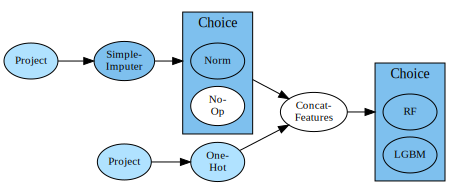

In [4]:
project_nums = Project(columns={'type': 'number'})
project_cats = Project(columns={'type': 'string'})
planned_pipeline = (
       (project_nums >> SimpleImputer >> (Norm | NoOp) & project_cats >> OneHot(handle_unknown='ignore'))
    >> ConcatFeatures
    >> (RF | LGBM))

planned_pipeline.visualize()

In [5]:
import sklearn.metrics
from lale.lib.lale import Hyperopt
auto_optimizer = Hyperopt(estimator=planned_pipeline, cv=3, max_evals=5, scoring='balanced_accuracy')
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
acc = sklearn.metrics.balanced_accuracy_score(test_y, auto_y)
print(f'balanced accuracy {acc:.1%}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/trial, best loss: -0.6571319677581537]
balanced accuracy 68.8%


### Displaying Hyperopt Results

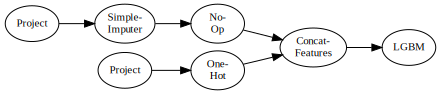

In [6]:
best_pipeline = auto_trained.get_pipeline()
best_pipeline.visualize()

In [7]:
auto_trained.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,-0.657132,0.935341,0.685404,ok
p1,1,-0.500000,0.344880,0.614624,ok
p2,2,-0.500000,0.242835,0.614632,ok
p3,3,-0.500000,0.292962,0.561982,ok
p4,4,-0.652196,0.892684,0.878620,ok


### Specify objectives for Multi-objective optimization

In [8]:
from sklearn.metrics import make_scorer, get_scorer

# Define sklearn scorer for computing False Positive Rate (FPR)
def compute_fpr(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = round(fp / (fp + tn), 4)
    return fpr

fpr_scorer = make_scorer(compute_fpr, greater_is_better=False)

# Specify scoring params passed to Multi-objective Optimizer
scoring = ['balanced_accuracy', fpr_scorer]  
best_score = [1, 0]

# Let's also get scorers to compute the metrics value on optimizer's outputs
scorer = [get_scorer(scorer) for scorer in scoring]
print('Metric values using single obj best pipeline %.3f %.3f' \
      %(scorer[0](best_pipeline, test_X, test_y), \
        -scorer[1](best_pipeline, test_X, test_y)))

Metric values using single obj best pipeline 0.688 0.479


### Perform Multi-objective optimization

In [9]:
from lalegpl.lib.lale import NSGA2
from lale.lib.lale import OptimizeLast

In [10]:
# Parameters used when creating instance of Multi-objective optimizer 
optimizer_args = {
    'scoring' : scoring,
    'best_score': best_score,
    'cv' : 3,
    'max_evals' : 30,
    # 'max_opt_time': 120, \
    'population_size' : 10
}

# Create operator for performing MOO on final estimator of best pipeline from single obj optimizer 
optFinalEstimator = OptimizeLast(
    estimator = best_pipeline,
    last_optimizer=NSGA2,
    optimizer_args = optimizer_args
)

In [11]:
%%time
opt_trained = optFinalEstimator.fit(train_X, train_y)

CPU times: user 3min 4s, sys: 1.71 s, total: 3min 6s
Wall time: 24.5 s


In [12]:
# Currently predict uses first pipeline in pareto-front
pred_y = opt_trained.predict(test_X)
acc = sklearn.metrics.balanced_accuracy_score(test_y, pred_y)
print(f'balanced accuracy {acc:.1%}')

balanced accuracy 69.5%


In [13]:
# get_pipeline() currently returns first pipeline by default
pareto_pipeline = opt_trained.get_pipeline()

print('scorer values %.3f %.3f' \
      %(scorer[0](pareto_pipeline, test_X, test_y), \
        scorer[1](pareto_pipeline, test_X, test_y)))

scorer values 0.695 -0.448


### Display Pareto-front obtained after Multi-objective optimization

In [14]:
# Call summary() routine to list the pareto-optimal solutions with corresponding loss values
opt_trained.summary()

,id,loss1,loss2
name,,,
p0,0,0.318372,0.495100
p1,1,0.519541,0.107833
p2,2,0.440544,0.450967
p3,3,0.490923,0.343133
p4,4,0.332029,0.490200
p5,5,0.479196,0.348033


Pareto optimal pipeline p0:


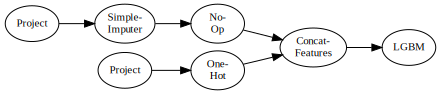

```python
pipeline = LGBM(
    boosting_type="dart",
    colsample_bytree=0.8140202419772428,
    learning_rate=0.763514659936432,
    min_child_samples=7,
    min_child_weight=0.009838340927750404,
    n_estimators=363,
    num_leaves=4,
    reg_alpha=0.47388218727466036,
    reg_lambda=0.8015309799850072,
    subsample=0.9716881978352767,
    subsample_freq=2,
)
```

Pareto optimal pipeline p1:


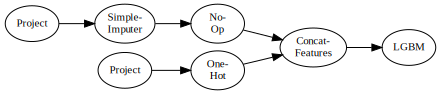

```python
pipeline = LGBM(
    boosting_type="dart",
    colsample_bytree=0.12361040955142955,
    learning_rate=0.9387457436977276,
    min_child_samples=16,
    min_child_weight=0.007708200858802182,
    n_estimators=779,
    num_leaves=16,
    reg_alpha=0.9983624588257038,
    reg_lambda=0.5963792560922511,
    subsample=0.20885545841567957,
    subsample_freq=3,
)
```

Pareto optimal pipeline p2:


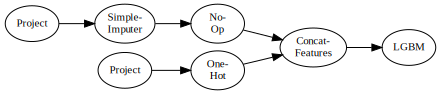

```python
pipeline = LGBM(
    boosting_type="dart",
    colsample_bytree=0.1541373840118991,
    learning_rate=0.7768472073617742,
    min_child_samples=9,
    min_child_weight=0.0038049783034339404,
    n_estimators=791,
    num_leaves=32,
    reg_alpha=0.9101271603002484,
    reg_lambda=0.6079306285553989,
    subsample=0.9071735313745659,
)
```

Pareto optimal pipeline p3:


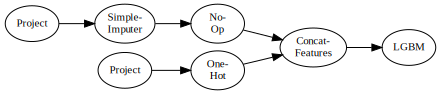

```python
pipeline = LGBM(
    boosting_type="dart",
    colsample_bytree=0.15787709651744036,
    learning_rate=0.8692231822123285,
    min_child_samples=16,
    min_child_weight=0.006994546349121872,
    n_estimators=740,
    num_leaves=4,
    reg_alpha=0.9314060580701335,
    reg_lambda=0.7502437192327184,
    subsample=0.8446433068529873,
    subsample_freq=5,
)
```

Pareto optimal pipeline p4:


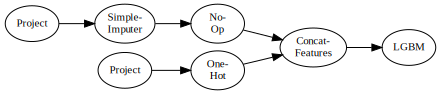

```python
pipeline = LGBM(
    colsample_bytree=0.1541373840118991,
    learning_rate=0.7768472073617742,
    min_child_samples=12,
    min_child_weight=0.0037121855341829524,
    n_estimators=927,
    num_leaves=4,
    reg_alpha=0.9101271603002484,
    reg_lambda=0.9303489957216984,
    subsample=0.8979264104055359,
    subsample_freq=5,
)
```

Pareto optimal pipeline p5:


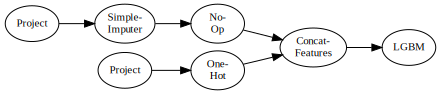

```python
pipeline = LGBM(
    boosting_type="dart",
    colsample_bytree=0.8166596719847218,
    learning_rate=0.763514659936432,
    min_child_samples=8,
    min_child_weight=0.009838340927750404,
    n_estimators=247,
    num_leaves=4,
    reg_alpha=0.47388218727466036,
    reg_lambda=0.8015309799850072,
    subsample=0.05331746088180134,
    subsample_freq=2,
)
```

In [15]:
for pname in opt_trained.summary().index:
    print(f'Pareto optimal pipeline {pname}:')
    p = opt_trained.get_pipeline(pname)
    p.visualize()
    p.get_last().pretty_print(ipython_display=True, show_imports=False)
    
    

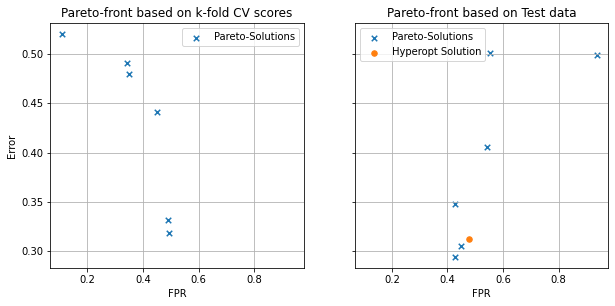

In [16]:
import matplotlib.pyplot as plt
figs, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4.5))

pareto_pipelines  = [opt_trained.get_pipeline(pipeline_name=id) for id in opt_trained.summary().index.tolist()]
df_cv = opt_trained.summary()

cols = ['loss1' , 'loss2']
label_dict = {'loss1' : 'Error', 'loss2' : 'FPR'}

# Let's put loss2 on X-axis
ax = axs[0]
ax.scatter(df_cv['loss2'], df_cv['loss1'], s=30, marker='x', label='Pareto-Solutions')
ax.set_xlabel(label_dict['loss2'])
ax.set_ylabel(label_dict['loss1'])
ax.grid()
ax.legend()
ax.set_title("Pareto-front based on k-fold CV scores")

# Let's evaluate the pareto-optimal pipelines on test data
pX, pY = [], []
for pipeline in pareto_pipelines:
    obj1_value = best_score[0] - scorer[0](pipeline, test_X, test_y)
    obj2_value = best_score[1] - scorer[1](pipeline, test_X, test_y)
    
    pX.append(obj1_value)
    pY.append(obj2_value)

dict = {'loss1' : pX, 'loss2' : pY}
df = pd.DataFrame(dict)    
    
# Metric values using single objective best pipeline    
sopt_err = best_score[0] - scorer[0](best_pipeline, test_X, test_y)
sopt_fpr = best_score[1] - scorer[1](best_pipeline, test_X, test_y)
    

ax = axs[1]
ax.scatter(df['loss2'], df['loss1'], s=30, marker='x', label='Pareto-Solutions')
ax.scatter(sopt_fpr, sopt_err, s=30, marker='o', label='Hyperopt Solution')
ax.set_xlabel(label_dict['loss2'])
# plt.ylabel(label_dict['loss1'])
ax.grid()
ax.legend()
ax.set_title("Pareto-front based on Test data")

plt.show()
